# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

# Part 1: Get the data

Skip this part if you load stored numpy arrays (Mirai*.npy) (which is recommended)

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Skip this part if you run on the CPU

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [ ]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

# Part 3: Hardware

Skip questions 1, 2, 3, 5, 6 if you use your own computer.

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on.

Question 1: What graphics card is available in the cloud machine? Run 'nvidia-smi' in the terminal. 

Question 2: Google the name of the graphics card, how many CUDA cores does it have?

Question 3: How much memory does the graphics card have?

Question 4: What is stored in the GPU memory while training a DNN ?

**Answer**: 

During the training of a DNN the GPU memory stores:
- Weights and Biases of the network
- Intermediate calculation results from the forward pass
- Workspace such as local variables

Question 5: What CPU is available in the cloud machine? How many cores does it have? Run 'lscpu' in the terminal.

Question 6: How much CPU memory (RAM) is available in the cloud machine? Run 'free -g' in the terminal.

# Part 4: Load the data

To make this step easier, directly load the data from saved numpy arrays (.npy) (recommended)


Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. 

We will use the function `genfromtxt` to load the data.

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.


In [1]:
from numpy import genfromtxt
import numpy as np


# Load data from numpy arrays
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')

# Remove the first 24 covariates (columns)
X = np.delete(X, np.s_[0:24], 1)

print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class
unique, counts = np.unique(Y, return_counts=True)
print('################')
print('# cls | number #')
print('################')
for cls, count in zip(unique, counts):
    print(f'# {cls} | {count} #')
print('################')

The covariates have size (764137, 92).
The labels have size (764137,).
################
# cls | number #
################
# 0.0 | 121621 #
# 1.0 | 642516 #
################


# Part 5: How good is a naive classifier?

Question 7: Given the number of examples from each class, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by guessing that all examples belong to one class.

**Answer**: The naive classifier can reach $\max({\frac{NumberObjectsClass_1}{NumberAllObjects},\frac{NumberObjectsClass_2}{NumberAllObjects}})$ accuracy.

In [2]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()

# Print the number of NaNs (not a number) in the labels
print(f'Number of NaNs in labels: {sum(np.isnan(Y))}')

# Print the number of NaNs in the covariates
print(f'Number of NaNs in covariates: {sum(np.isnan(X))}')


Number of NaNs in labels: 0
Number of NaNs in covariates: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# Part 6: Preprocessing

Lets do some simple preprocessing

In [3]:
# Convert covariates to floats
X = X.astype(float)

# Convert labels to integers
Y = Y.astype(int)

# Remove mean of each covariate (column)
for cov in range(X.shape[1]):
    X[:, cov] = X[:, cov]-np.mean(X[:, cov])
    
# Divide each covariate (column) by its standard deviation
for cov in range(X.shape[1]):
    X[:, cov] = X[:, cov] / np.std(X[:, cov])

# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print(f'Mean: {round(np.mean(X))}')
print(f'Std: {round(np.std(X))}')

Mean: 0
Std: 1


# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)

We use a function from scikit learn.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [4]:
from sklearn.model_selection import train_test_split

# Your code
Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(X, Y, test_size=0.3, random_state=42)

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%

# TRAIN DATA
uniqueTrain, countsTrain = np.unique(Ytrain, return_counts=True)
print('\nTRAINING DATA')
print('################')
print('# cls | number #')
print('################')
for cls, count in zip(uniqueTrain, countsTrain):
    print(f'# {cls} | {count} ')
print('################')

# REMAINING DATA
uniqueTemp, countsTemp = np.unique(Ytemp, return_counts=True)
print('\nREMAINING DATA')
print('################')
print('# cls | number #')
print('################')
for cls, count in zip(uniqueTemp, countsTemp):
    print(f'# {cls} | {count} ')
print('################')

Xtrain has size (534895, 92).
Ytrain has size (534895,).
Xtemp has size (229242, 92).
Ytemp has size (229242,).

TRAINING DATA
################
# cls | number #
################
# 0 | 85248 
# 1 | 449647 
################

REMAINING DATA
################
# cls | number #
################
# 0 | 36373 
# 1 | 192869 
################


#  Part 8: Split non-training data data into validation and test
Now split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Do all variables (Xtrain,Ytrain), (Xval,Yval), (Xtest,Ytest) have the shape that you expect?

In [5]:
from sklearn.model_selection import train_test_split


Xval, Xtest, Yval, Ytest = train_test_split(Xtemp, Ytemp, test_size=0.5, random_state=42)

print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The validation and test data have size (114621, 92), (114621, 92), (114621,) and (114621,)


# Part 9: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

For different parts of this notebook you need to go back here, add more things, and re-run this cell to re-define the build function.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


In [124]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras.optimizers import SGD, Adam
from keras.losses import BinaryCrossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    if optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Input(shape=input_shape))
    model.add(Dense(n_nodes, activation=act_fun))
    
    # Add BatchNormalization
    if use_bn:
        model.add(BatchNormalization())
    
    # Add Dropout
    if use_dropout:
        model.add(Dropout(0.5))
        
    # Add Custom Dropout
    if use_custom_dropout:
        model.add(myDropout(0.5))
        
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=act_fun))
        if use_bn:
            model.add(BatchNormalization())
        if use_dropout:
            model.add(Dropout(0.5))
        if use_custom_dropout:
            model.add(myDropout(0.5))
    
    # Final layer
    model.add(Dense(1, activation=act_fun))
    
    # Compile model
    model.compile(optimizer=optimizer,
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])
    
    return model

In [63]:
# Lets define a help function for plotting the training results

import matplotlib.pyplot as plt
def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 10: Train the DNN

Time to train the DNN, we start simple with 2 layers with 20 nodes each, learning rate 0.1.

Relevant functions

`build_DNN`, the function we defined in Part 9, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


### 2 layers, 20 nodes

In [65]:
# Setup some training parameters
batch_size = 10000
epochs = 20

input_shape = (X.shape[1],)

# Build the model
model1 = build_DNN(input_shape, n_layers=2, n_nodes=20, learning_rate=0.1)

# Train the model, provide training data and validation data
history1 = model1.fit(Xtrain,
                      Ytrain, 
                      batch_size=batch_size, 
                      epochs=epochs, 
                      validation_data=(Xval, Yval))

Epoch 1/20
54/54 [==============================] - 1s 8ms/step - loss: 0.4588 - accuracy: 0.7448 - val_loss: 0.2149 - val_accuracy: 0.8841
Epoch 2/20
54/54 [==============================] - 0s 4ms/step - loss: 0.2079 - accuracy: 0.8917 - val_loss: 0.1901 - val_accuracy: 0.9055
Epoch 3/20
54/54 [==============================] - 0s 4ms/step - loss: 0.1892 - accuracy: 0.9040 - val_loss: 0.1815 - val_accuracy: 0.9072
Epoch 4/20
54/54 [==============================] - 0s 4ms/step - loss: 0.1819 - accuracy: 0.9056 - val_loss: 0.1766 - val_accuracy: 0.9082
Epoch 5/20
54/54 [==============================] - 0s 4ms/step - loss: 0.1776 - accuracy: 0.9063 - val_loss: 0.1734 - val_accuracy: 0.9087
Epoch 6/20
54/54 [==============================] - 0s 4ms/step - loss: 0.1750 - accuracy: 0.9062 - val_loss: 0.1708 - val_accuracy: 0.9091
Epoch 7/20
54/54 [==============================] - 0s 4ms/step - loss: 0.1726 - accuracy: 0.9064 - val_loss: 0.1689 - val_accuracy: 0.9095
Epoch 8/20
54/54 [==

In [66]:
# Evaluate the model on the test data
score = model1.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 2s 677us/step - loss: 0.1596 - accuracy: 0.9154
Test loss: 0.1596
Test accuracy: 0.9154


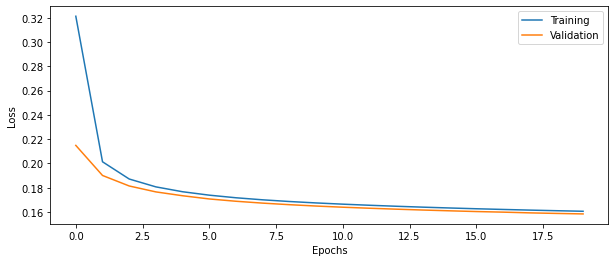

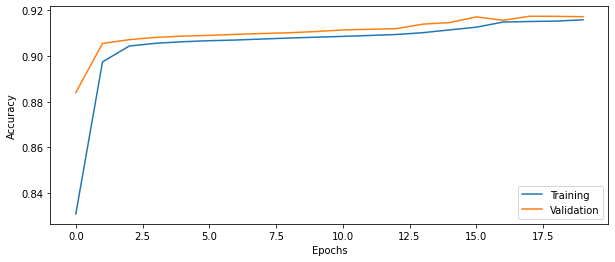

In [67]:
# Plot the history from the training run
plot_results(history1)

# Part 11: More questions

Question 8: What happens if you add several Dense layers without specifying the activation function?

Answer: There won't be any activation which results in a linear model.

Question 9: How are the weights in each dense layer initialized as default? How are the bias weights initialized?

Answer: The Dense layer class offers the attributes **kernel_initializer** and **bias_initializer** which are used to initialize the kernel weights matrix as well as the bias vector. By default the weights and bias are initialized as **glorot_uniform** and **zeros** respectively.

# Part 12: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

In [32]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight("balanced", unique, Y)

# Print the class weights
print(class_weights)

# Keras wants the weights in this form, uncomment and change value1 and value2 to your weights, 
# or get them from the array that is returned from class_weight

class_weights = {0: class_weights[0],
                 1: class_weights[1]}

print(class_weights)

[3.14146817 0.59464434]
{0: 3.1414681675039673, 1: 0.5946443357052587}


### 2 layers, 20 nodes, class weights

In [36]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model2 = build_DNN(input_shape, 
                   n_layers=2, 
                   n_nodes=20, 
                   learning_rate=0.1)

history2 = model2.fit(Xtrain,
                      Ytrain,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(Xval, Yval), 
                      class_weight=class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
54/54 [==============================] - 1s 8ms/step - loss: 0.4213 - accuracy: 0.8707 - val_loss: 0.2823 - val_accuracy: 0.8821
Epoch 2/20
54/54 [==============================] - 0s 4ms/step - loss: 0.2274 - accuracy: 0.8813 - val_loss: 0.2597 - val_accuracy: 0.8865
Epoch 3/20
54/54 [==============================] - 0s 4ms/step - loss: 0.2085 - accuracy: 0.8868 - val_loss: 0.2463 - val_accuracy: 0.8944
Epoch 4/20
54/54 [==============================] - 0s 4ms/step - loss: 0.2006 - accuracy: 0.8945 - val_loss: 0.2398 - val_accuracy: 0.8999
Epoch 5/20
54/54 [==============================] - 0s 4ms/step - loss: 0.1944 - accuracy: 0.8987 - val_loss: 0.2360 - val_accuracy: 0.9017
Epoch 6/20
54/54 [==============================] - 0s 4ms/step - loss: 0.1911 - accuracy: 0.9003 - val_loss: 0.2321 - val_accuracy: 0.9032
Epoch 7/20
54/54 [====

In [38]:
# Evaluate model on test data
score = model2.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 2s 510us/step - loss: 0.2232 - accuracy: 0.9107
Test loss: 0.2232
Test accuracy: 0.9107


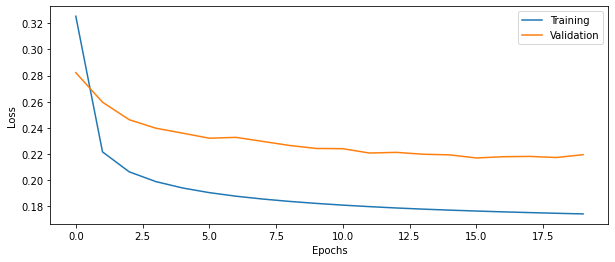

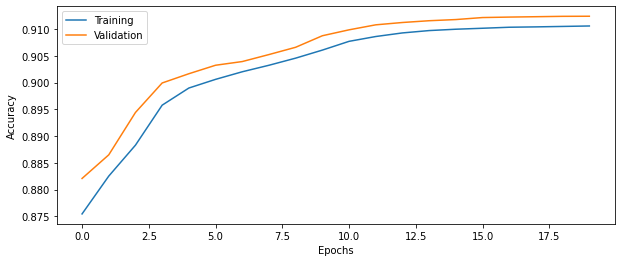

In [39]:
plot_results(history2)

# Part 13: More questions

Skip questions 11 and 12 if you run on the CPU

Question 10: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

**Answer**: In most cases the training data would not fit into GPU memory. Thus, we need to split up the data into batches of smaller size. We try to store the data in CPU memory and feed the batches to GPU memory.

Question 11: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the cloud computer a few times during training.

Skip

Question 12: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 

Skip

Question 13: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  

**Answer**: 

$WeightUpdatesPerEpoch = \frac{NumberTrainingExamples}{BatchSize}$

$5349 = \frac{534895}{100}$

$535 = \frac{534895}{1000}$

$54 = \frac{534895}{10000}$

Question 14: What limits how large the batch size can be?

**Answer**: 

- A larger batch size will cause a higher generalization error. Thus, if we want a model that generalizes well, we cannot choose too big of a batch size.
- GPU memory strictly limits how large the batch size can be because the batch size determines the amount of intermediate calculations that need to be stored in memory. 


Question 15: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?

**Answer**: Batch size and learning rate are closely related. If the batch size is decreased, the learning rate should be decreased as well as the gradient becomes more uncertain having less samples.

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

# Part 14: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 16: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()

**Answer**: 

- Network with 4 dense layers and 50 nodes: **12351** parameters
- Network with 2 dense layers and 20 nodes: **2301** parameters

### 4 layers, 20 nodes, class weights

In [70]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model3 = build_DNN(input_shape, 
                   n_layers=4, 
                   n_nodes=20, 
                   learning_rate=0.1)

history3 = model3.fit(Xtrain,
                      Ytrain,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(Xval, Yval), 
                      class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 1s 11ms/step - loss: 0.4261 - accuracy: 0.8298 - val_loss: 0.2436 - val_accuracy: 0.9024
Epoch 2/20
54/54 [==============================] - 0s 6ms/step - loss: 0.1952 - accuracy: 0.9010 - val_loss: 0.2269 - val_accuracy: 0.9053
Epoch 3/20
54/54 [==============================] - 0s 5ms/step - loss: 0.1857 - accuracy: 0.9037 - val_loss: 0.2250 - val_accuracy: 0.9079
Epoch 4/20
54/54 [==============================] - 0s 6ms/step - loss: 0.1825 - accuracy: 0.9065 - val_loss: 0.2265 - val_accuracy: 0.9095
Epoch 5/20
54/54 [==============================] - 0s 5ms/step - loss: 0.1796 - accuracy: 0.9081 - val_loss: 0.2203 - val_accuracy: 0.9107
Epoch 6/20
54/54 [==============================] - 0s 6ms/step - loss: 0.1786 - accuracy: 0.9087 - val_loss: 0.2162 - val_accuracy: 0.9115
Epoch 7/20
54/54 [==============================] - 0s 6ms/step - loss: 0.1765 - accuracy: 0.9096 - val_loss: 0.2204 - val_accuracy: 0.9118
Epoch 8/20
54/54 [=

In [48]:
# Trainable parameters 2 layers 20 nodes
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 20)                1860      
_________________________________________________________________
dense_16 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 21        
Total params: 2,301
Trainable params: 2,301
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Trainable parameters 4 layers 50 nodes
model3.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 50)                4650      
_________________________________________________________________
dense_34 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_35 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_36 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 51        
Total params: 12,351
Trainable params: 12,351
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Evaluate model on test data
score = model3.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 2s 550us/step - loss: 0.2534 - accuracy: 0.9106
Test loss: 0.2534
Test accuracy: 0.9106


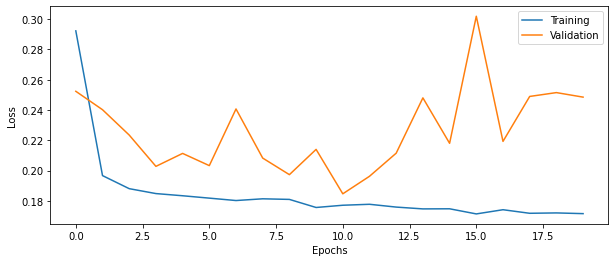

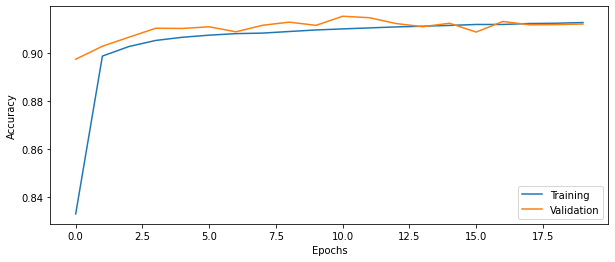

In [51]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [54]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model4 = build_DNN(input_shape, 
                   n_layers=2, 
                   n_nodes=50, 
                   learning_rate=0.1)

history4 = model4.fit(Xtrain,
                      Ytrain,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(Xval, Yval), 
                      class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 1s 9ms/step - loss: 0.3655 - accuracy: 0.8832 - val_loss: 0.2740 - val_accuracy: 0.8926
Epoch 2/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2169 - accuracy: 0.8930 - val_loss: 0.2482 - val_accuracy: 0.8981
Epoch 3/20
54/54 [==============================] - 0s 5ms/step - loss: 0.2027 - accuracy: 0.8964 - val_loss: 0.2381 - val_accuracy: 0.8997
Epoch 4/20
54/54 [==============================] - 0s 5ms/step - loss: 0.1951 - accuracy: 0.8981 - val_loss: 0.2373 - val_accuracy: 0.9007
Epoch 5/20
54/54 [==============================] - 0s 5ms/step - loss: 0.1908 - accuracy: 0.8992 - val_loss: 0.2330 - val_accuracy: 0.9019
Epoch 6/20
54/54 [==============================] - 0s 6ms/step - loss: 0.1875 - accuracy: 0.9005 - val_loss: 0.2273 - val_accuracy: 0.9040
Epoch 7/20
54/54 [==============================] - 0s 6ms/step - loss: 0.1860 - accuracy: 0.9019 - val_loss: 0.2282 - val_accuracy: 0.9052
Epoch 8/20
54/54 [==

In [55]:
# Evaluate model on test data
score = model4.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 2s 594us/step - loss: 0.2179 - accuracy: 0.9110
Test loss: 0.2179
Test accuracy: 0.9110


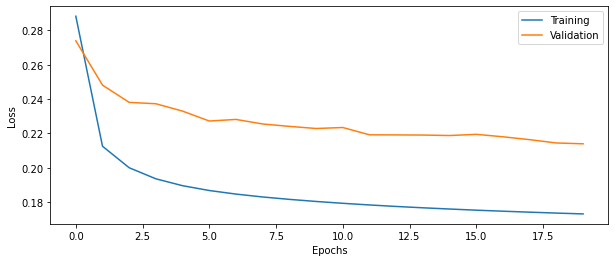

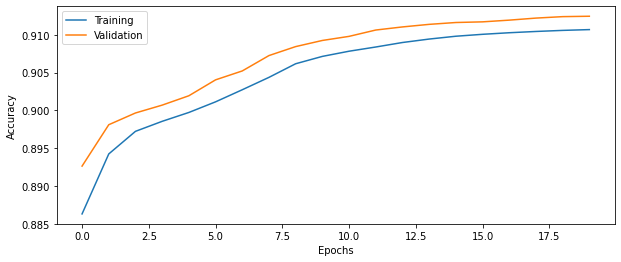

In [56]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [71]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model5 = build_DNN(input_shape, 
                   n_layers=4, 
                   n_nodes=50, 
                   learning_rate=0.1)

history5 = model5.fit(Xtrain,
                      Ytrain,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(Xval, Yval), 
                      class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 2s 15ms/step - loss: 0.3265 - accuracy: 0.8879 - val_loss: 0.2446 - val_accuracy: 0.8989
Epoch 2/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1956 - accuracy: 0.8980 - val_loss: 0.2389 - val_accuracy: 0.9024
Epoch 3/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1864 - accuracy: 0.9019 - val_loss: 0.2856 - val_accuracy: 0.9004
Epoch 4/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1863 - accuracy: 0.9041 - val_loss: 0.2609 - val_accuracy: 0.9035
Epoch 5/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1817 - accuracy: 0.9066 - val_loss: 0.1908 - val_accuracy: 0.9122
Epoch 6/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1828 - accuracy: 0.9069 - val_loss: 0.2054 - val_accuracy: 0.9116
Epoch 7/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1796 - accuracy: 0.9084 - val_loss: 0.2122 - val_accuracy: 0.9116
Epoch 8/20
54

In [72]:
# Evaluate model on test data
score = model5.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 3s 811us/step - loss: 0.2106 - accuracy: 0.91170s - loss: 0.210
Test loss: 0.2106
Test accuracy: 0.9117


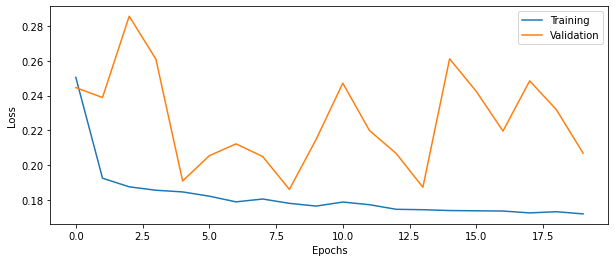

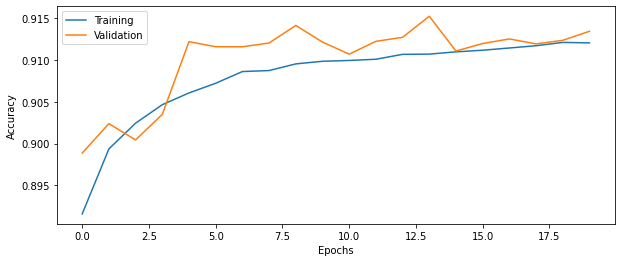

In [73]:
plot_results(history5)

# Part 15: Batch normalization

Now add batch normalization after each dense layer in `build_DNN`. Remember to import BatchNormalization from keras.layers. 

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 17: Why is batch normalization important when training deep networks?

**Answer**: Batch normalization is used to normalize inputs and keep the mean output around 0 as well as the  output standard deviation around 1. Thus, it is a method to make the network more performant, robust and stable.
For deep neural networks, we use batch normalization not only to normalize the inputs but also the output of each layer.

### 2 layers, 20 nodes, class weights, batch normalization

In [78]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model6 = build_DNN(input_shape, 
                   n_layers=2, 
                   n_nodes=20, 
                   learning_rate=0.1, 
                   use_bn=True)

history6 = model6.fit(Xtrain,
                      Ytrain,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(Xval, Yval), 
                      class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 4s 15ms/step - loss: 0.3559 - accuracy: 0.8413 - val_loss: 0.4142 - val_accuracy: 0.8404
Epoch 2/20
54/54 [==============================] - 0s 9ms/step - loss: 0.2341 - accuracy: 0.8938 - val_loss: 0.3529 - val_accuracy: 0.8404
Epoch 3/20
54/54 [==============================] - 1s 9ms/step - loss: 0.2071 - accuracy: 0.9019 - val_loss: 0.3073 - val_accuracy: 0.8404
Epoch 4/20
54/54 [==============================] - 1s 9ms/step - loss: 0.1957 - accuracy: 0.9063 - val_loss: 0.2544 - val_accuracy: 0.8407
Epoch 5/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1882 - accuracy: 0.9081 - val_loss: 0.2086 - val_accuracy: 0.8660
Epoch 6/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1852 - accuracy: 0.9085 - val_loss: 0.1811 - val_accuracy: 0.9086
Epoch 7/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1810 - accuracy: 0.9106 - val_loss: 0.1766 - val_accuracy: 0.9155
Epoch 8/20
54/54 [=

In [79]:
# Evaluate model on test data
score = model6.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 3s 772us/step - loss: 0.2035 - accuracy: 0.9174
Test loss: 0.2035
Test accuracy: 0.9174


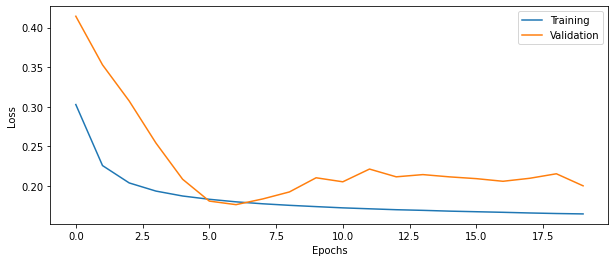

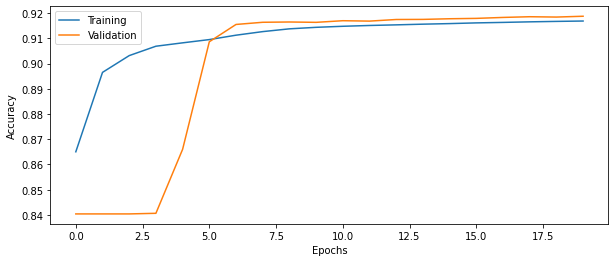

In [80]:
plot_results(history6)

# Part 16: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

https://keras.io/api/layers/activations/

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [81]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model7 = build_DNN(input_shape, 
                   n_layers=2, 
                   n_nodes=20, 
                   learning_rate=0.1, 
                   act_fun="relu")

history7 = model7.fit(Xtrain,
                      Ytrain,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(Xval, Yval), 
                      class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 1s 9ms/step - loss: 5.2054 - accuracy: 0.8013 - val_loss: 2.4334 - val_accuracy: 0.8404
Epoch 2/20
54/54 [==============================] - 0s 5ms/step - loss: 7.6499 - accuracy: 0.8403 - val_loss: 2.4334 - val_accuracy: 0.8404
Epoch 3/20
54/54 [==============================] - 0s 5ms/step - loss: 7.6212 - accuracy: 0.8409 - val_loss: 2.4334 - val_accuracy: 0.8404
Epoch 4/20
54/54 [==============================] - 0s 5ms/step - loss: 7.6224 - accuracy: 0.8409 - val_loss: 2.4334 - val_accuracy: 0.8404
Epoch 5/20
54/54 [==============================] - 0s 5ms/step - loss: 7.6439 - accuracy: 0.8404 - val_loss: 2.4334 - val_accuracy: 0.8404
Epoch 6/20
54/54 [==============================] - 0s 5ms/step - loss: 7.6757 - accuracy: 0.8398 - val_loss: 2.4334 - val_accuracy: 0.8404
Epoch 7/20
54/54 [==============================] - 0s 5ms/step - loss: 7.6352 - accuracy: 0.8406 - val_loss: 2.4334 - val_accuracy: 0.8404
Epoch 8/20
54/54 [==

In [82]:
# Evaluate model on test data
score = model7.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 2s 654us/step - loss: 2.4057 - accuracy: 0.8422
Test loss: 2.4057
Test accuracy: 0.8422


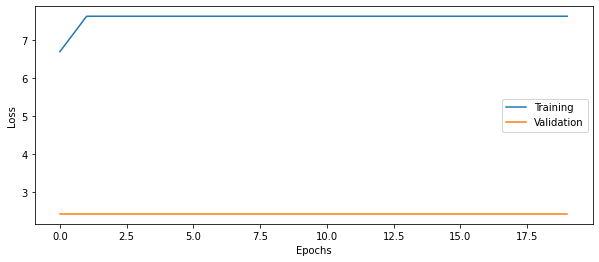

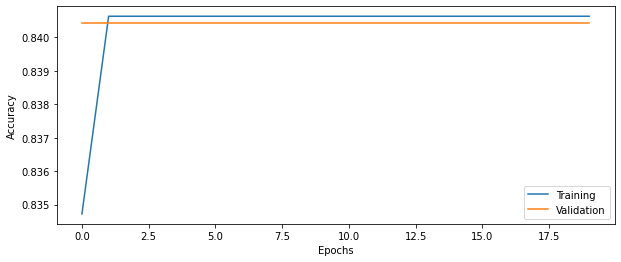

In [83]:
plot_results(history7)

# Part 17: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers. 

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [86]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model8 = build_DNN(input_shape, 
                   n_layers=2, 
                   n_nodes=20, 
                   learning_rate=0.1, 
                   optimizer='adam')

history8 = model8.fit(Xtrain,
                      Ytrain,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(Xval, Yval), 
                      class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 1s 12ms/step - loss: 0.3004 - accuracy: 0.8359 - val_loss: 0.2236 - val_accuracy: 0.9098
Epoch 2/20
54/54 [==============================] - 0s 6ms/step - loss: 0.1743 - accuracy: 0.9112 - val_loss: 0.2104 - val_accuracy: 0.9173
Epoch 3/20
54/54 [==============================] - 0s 6ms/step - loss: 0.1657 - accuracy: 0.9164 - val_loss: 0.2166 - val_accuracy: 0.9186
Epoch 4/20
54/54 [==============================] - 0s 6ms/step - loss: 0.1619 - accuracy: 0.9179 - val_loss: 0.2124 - val_accuracy: 0.9198
Epoch 5/20
54/54 [==============================] - 0s 5ms/step - loss: 0.1601 - accuracy: 0.9184 - val_loss: 0.1959 - val_accuracy: 0.9192
Epoch 6/20
54/54 [==============================] - 0s 5ms/step - loss: 0.1614 - accuracy: 0.9178 - val_loss: 0.1998 - val_accuracy: 0.9199
Epoch 7/20
54/54 [==============================] - 0s 5ms/step - loss: 0.1576 - accuracy: 0.9181 - val_loss: 0.1951 - val_accuracy: 0.9209
Epoch 8/20
54/54 [=

In [87]:
# Evaluate model on test data
score = model8.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 2s 659us/step - loss: 0.1653 - accuracy: 0.9248
Test loss: 0.1653
Test accuracy: 0.9248


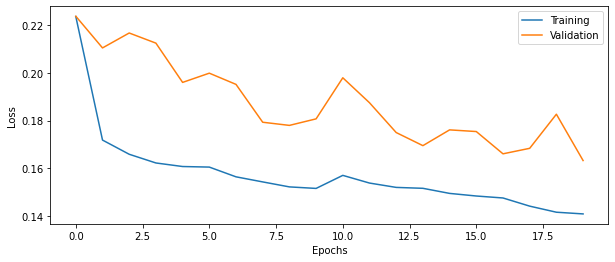

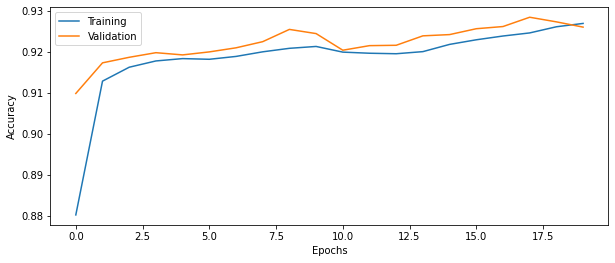

In [88]:
plot_results(history8)

# Part 18: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. 

Add a Dropout layer after each Dense layer (but not after the final dense layer) in `build_DNN`, with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/api/layers/regularization_layers/dropout/ for how the Dropout layer works.

---

Question 18: How does the validation accuracy change when adding dropout?

Question 19: How does the test accuracy change when adding dropout?

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [237]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model9 = build_DNN(input_shape, 
                   n_layers=2, 
                   n_nodes=20, 
                   learning_rate=0.1, 
                   use_dropout=True)

history9 = model9.fit(Xtrain,
                      Ytrain,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(Xval, Yval), 
                      class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 1s 11ms/step - loss: 0.7222 - accuracy: 0.4749 - val_loss: 0.6024 - val_accuracy: 0.8836
Epoch 2/20
54/54 [==============================] - 0s 6ms/step - loss: 0.6342 - accuracy: 0.6230 - val_loss: 0.5245 - val_accuracy: 0.8831
Epoch 3/20
54/54 [==============================] - 0s 6ms/step - loss: 0.5714 - accuracy: 0.6891 - val_loss: 0.4406 - val_accuracy: 0.8819
Epoch 4/20
54/54 [==============================] - 0s 6ms/step - loss: 0.5087 - accuracy: 0.7377 - val_loss: 0.3660 - val_accuracy: 0.8819
Epoch 5/20
54/54 [==============================] - 0s 6ms/step - loss: 0.4522 - accuracy: 0.7780 - val_loss: 0.3233 - val_accuracy: 0.8819
Epoch 6/20
54/54 [==============================] - 0s 6ms/step - loss: 0.4069 - accuracy: 0.8062 - val_loss: 0.2954 - val_accuracy: 0.8818
Epoch 7/20
54/54 [==============================] - 0s 6ms/step - loss: 0.3781 - accuracy: 0.8238 - val_loss: 0.2836 - val_accuracy: 0.8818
Epoch 8/20
54/54 [=

In [238]:
# Evaluate model on test data
score = model9.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 2s 601us/step - loss: 0.2645 - accuracy: 0.8842
Test loss: 0.2645
Test accuracy: 0.8842


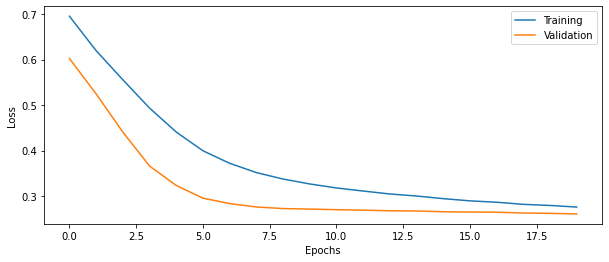

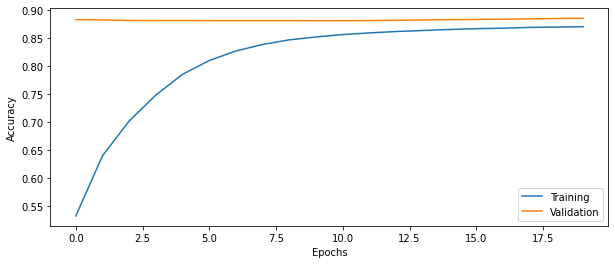

In [239]:
plot_results(history9)

# Part 19: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 20: How high classification accuracy can you achieve for the test data? What is your best configuration?

In [233]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# Adding batch_size to hyperparameter optimization 
# Overriding run_trial method in Hyperband class as suggested in 
# https://github.com/keras-team/keras-tuner/issues/122
class MyTuner(kerastuner.tuners.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', values=[32,64,128,256,512,1024,2048])
        super(MyTuner, self).run_trial(trial, *args, **kwargs)


def tune_model(hp):
    # Setting hyperparameter options
    n_layers = hp.Int('n_layers', min_value=2, max_value=5, step=1)
    n_nodes = hp.Int('n_nodes', min_value=20, max_value=50, step=10)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-2, 1e-3])
    act_fun = hp.Choice('act_fun', values=["sigmoid", "relu"])
    use_dropout = hp.Choice('use_dropout', values=[True, False])
    if use_dropout:
        dropout_rate = hp.Choice('dropout_rate', values=[0.1, 0.3, 0.5])
    use_bn = hp.Choice('use_bn', values=[True, False])

    # Setup optimizer, depending on input parameter string
    optimizer = Adam(learning_rate=learning_rate)
    
    # Add first layer, requires input shape
    inputs = keras.Input(shape=(92,))
    x = layers.Dense(units=n_nodes, activation=act_fun)(inputs)
    
    # Add BatchNormalization
    if use_bn:
        x = layers.BatchNormalization()(x)
    
    # Add Dropout
    if use_dropout:
        x = layers.Dropout(dropout_rate)(x)

        
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        x = layers.Dense(units=n_nodes, activation=act_fun)(x)
        if use_bn:
            x = layers.BatchNormalization()(x)
        if use_dropout:
            x = layers.Dropout(dropout_rate)(x)
    
    # Final layer
    outputs = layers.Dense(1, activation=hp.Choice('out_act_fun', values=["sigmoid", "relu", "softmax"]))(x)
    
    # Compile model
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=optimizer,
        loss=BinaryCrossentropy(),
        metrics=['accuracy'])
    
    return model

In [235]:
import kerastuner

tuner = MyTuner(
    tune_model,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2)

In [236]:
tuner.search(Xtrain, Ytrain, validation_data=(Xval, Yval), class_weight=class_weights)

Trial 180 Complete [00h 12m 09s]
val_accuracy: 0.9389902353286743

Best val_accuracy So Far: 0.946170449256897
Total elapsed time: 03h 04m 22s
INFO:tensorflow:Oracle triggered exit


In [244]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
n_layers: 4
n_nodes: 40
learning_rate: 0.001
act_fun: sigmoid
use_dropout: 0
dropout_rate: 0.1
use_bn: 1
out_act_fun: sigmoid
batch_size: 256
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 1609a0f52248e247c9cc85876c82b825
Score: 0.946170449256897
Trial summary
Hyperparameters:
n_layers: 3
n_nodes: 50
learning_rate: 0.001
act_fun: relu
use_dropout: 1
dropout_rate: 0.1
use_bn: 0
out_act_fun: sigmoid
batch_size: 32
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: f9eae1272c9602c832481db0340fda66
Score: 0.9430471062660217
Trial summary
Hyperparameters:
n_layers: 5
n_nodes: 30
learning_rate: 0.01
act_fun: sigmoid
use_dropout: 0
dropout_rate: 0.3
use_bn: 1
out_act_fun: sigmoid
batch_size: 1024
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2


In [245]:
# Find your best configuration for the DNN

# By implementing hyperparameter optimization we found the following parameters to return the best results.n_layers: 4
# n_layers: 4
# n_nodes: 40
# learning_rate: 0.001
# act_fun: sigmoid
# use_dropout: 0
# dropout_rate: 0.1 (can be ignored since use_dropout=False)
# use_bn: 1
# out_act_fun: sigmoid
# batch_size: 256
# tuner/epochs: 30


batch_size = 256
epochs = 30
input_shape = (X.shape[1],)

# Build and train model
model10 = build_DNN(input_shape, 
                   n_layers=4, 
                   n_nodes=40, 
                   learning_rate=0.001, 
                   optimizer='adam',
                   use_bn=True)

history10 = model10.fit(Xtrain,
                      Ytrain,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(Xval, Yval), 
                      class_weight=class_weights)

Epoch 1/30
2090/2090 [==============================] - 6s 2ms/step - loss: 0.2107 - accuracy: 0.9076 - val_loss: 0.2109 - val_accuracy: 0.9191
Epoch 2/30
2090/2090 [==============================] - 4s 2ms/step - loss: 0.1519 - accuracy: 0.9210 - val_loss: 0.1693 - val_accuracy: 0.9310
Epoch 3/30
2090/2090 [==============================] - 5s 2ms/step - loss: 0.1386 - accuracy: 0.9284 - val_loss: 0.1750 - val_accuracy: 0.9319
Epoch 4/30
2090/2090 [==============================] - 4s 2ms/step - loss: 0.1311 - accuracy: 0.9322 - val_loss: 0.1621 - val_accuracy: 0.9337
Epoch 5/30
2090/2090 [==============================] - 4s 2ms/step - loss: 0.1285 - accuracy: 0.9333 - val_loss: 0.1751 - val_accuracy: 0.9337
Epoch 6/30
2090/2090 [==============================] - 4s 2ms/step - loss: 0.1256 - accuracy: 0.9347 - val_loss: 0.1499 - val_accuracy: 0.9348
Epoch 7/30
2090/2090 [==============================] - 5s 2ms/step - loss: 0.1243 - accuracy: 0.9349 - val_loss: 0.1490 - val_accuracy:

In [246]:
# Evaluate DNN on test data
score = model10.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 3s 796us/step - loss: 0.1670 - accuracy: 0.9414
Test loss: 0.1670
Test accuracy: 0.9414


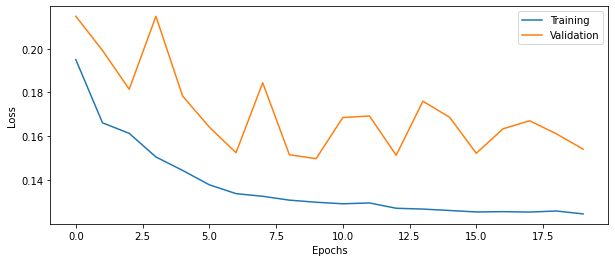

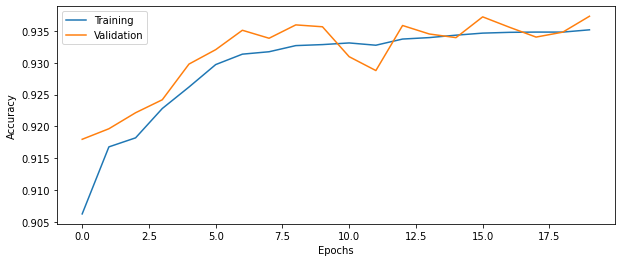

In [222]:
plot_results(history10)

# Part 20: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN. The `build_DNN` function takes two boolean arguments, use_dropout and use_custom_dropout, add a standard Dropout layer if use_dropout is true, add a myDropout layer if use_custom_dropout is true.

Run the same test data through the trained network 100 times, with dropout turned on. 

Question 21: What is the mean and the standard deviation of the test accuracy?

In [122]:
import keras.backend as K
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [247]:
# Your best training parameters
batch_size = 256
epochs = 30
input_shape = (X.shape[1],)

# Build and train model
model11 = build_DNN(input_shape, 
                   n_layers=4, 
                   n_nodes=40, 
                   learning_rate=0.001, 
                   optimizer='adam',
                   use_bn=True,
                   use_custom_dropout=True)

history11 = model11.fit(Xtrain,
                      Ytrain,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(Xval, Yval), 
                      class_weight=class_weights)

Epoch 1/30
2090/2090 [==============================] - 7s 3ms/step - loss: 0.3229 - accuracy: 0.8561 - val_loss: 0.2268 - val_accuracy: 0.9144
Epoch 2/30
2090/2090 [==============================] - 5s 3ms/step - loss: 0.1852 - accuracy: 0.9121 - val_loss: 0.2333 - val_accuracy: 0.9152
Epoch 3/30
2090/2090 [==============================] - 6s 3ms/step - loss: 0.1827 - accuracy: 0.9130 - val_loss: 0.2281 - val_accuracy: 0.9171
Epoch 4/30
2090/2090 [==============================] - 5s 3ms/step - loss: 0.1787 - accuracy: 0.9141 - val_loss: 0.2252 - val_accuracy: 0.9174
Epoch 5/30
2090/2090 [==============================] - 5s 3ms/step - loss: 0.1760 - accuracy: 0.9148 - val_loss: 0.2145 - val_accuracy: 0.9174
Epoch 6/30
2090/2090 [==============================] - 5s 3ms/step - loss: 0.1735 - accuracy: 0.9153 - val_loss: 0.2108 - val_accuracy: 0.9168
Epoch 7/30
2090/2090 [==============================] - 6s 3ms/step - loss: 0.1735 - accuracy: 0.9146 - val_loss: 0.2120 - val_accuracy:

In [248]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model11.evaluate(Xtest, Ytest)
                       
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 3s 856us/step - loss: 0.2088 - accuracy: 0.9193
Test accuracy: 0.9193


In [249]:
# Run the testing 100 times, and save the accuracies in an array
results = []

for _ in range(1,100):
    results.append(model11.evaluate(Xtest, Ytest)[1])
    
# Calculate and print mean and std of accuracies
print(f"Mean: {np.mean(results)}\nStd: {np.std(results)}")


3582/3582 [==============================] - 3s 912us/step - loss: 0.2090 - accuracy: 0.9195


3582/3582 [==============================] - 3s 770us/step - loss: 0.2088 - accuracy: 0.9194
Mean: 0.9193406725170636
Std: 0.00011291050872139227


# Part 21: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 22: What is the mean and the standard deviation of the test accuracy?

Question 23: What is the main advantage of dropout compared to CV for estimating test uncertainty? The difference may not be so large in this notebook, but imagine that you have a network that takes 24 hours to train.

In [250]:
from sklearn.model_selection import StratifiedKFold

# Store results
results_cv = {}

# Define 10-fold cross validation
skf = StratifiedKFold(n_splits=10, random_state=1234, shuffle=True)

i = 1
# Loop over cross validation folds
for train_index, test_index in skf.split(X, Y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index] 
    
    # Calculate class weights for current split
    class_weights = class_weight.compute_class_weight("balanced", np.unique(y_train), y_train)
    class_weights = {0: class_weights[0], 1: class_weights[1]}
    
    # Rebuild the DNN model, to not continue training on the previously trained model
    batch_size = 256
    epochs = 30
    input_shape = (X_train.shape[1],)

    # Build and train model
    model12 = build_DNN(input_shape, 
                       n_layers=4, 
                       n_nodes=40, 
                       learning_rate=0.001, 
                       optimizer='adam',
                       use_bn=True)


    # Fit the model with training set and class weights for this fold
    history12 = model12.fit(X_train,
                          y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          class_weight=class_weights)
    
    # Evaluate the model using the test set for this fold
    score = model12.evaluate(Xtest, Ytest)
    # Save the test accuracy in an array
    
    results_cv[i] = score[1]
    i += 1


TRAIN: [     0      1      2 ... 764134 764135 764136] TEST: [    18     28     33 ... 764111 764114 764116]


/Users/yuki/opt/miniconda3/envs/deeplearning/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Epoch 1/30
2687/2687 [==============================] - 8s 2ms/step - loss: 0.1953 - accuracy: 0.9122
Epoch 2/30
2687/2687 [==============================] - 6s 2ms/step - loss: 0.1401 - accuracy: 0.9282
Epoch 3/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1311 - accuracy: 0.9328
Epoch 4/30
2687/2687 [==============================] - 6s 2ms/step - loss: 0.1273 - accuracy: 0.9341
Epoch 5/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1259 - accuracy: 0.9351
Epoch 6/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1234 - accuracy: 0.9359
Epoch 7/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1201 - accuracy: 0.9372
Epoch 8/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1180 - accuracy: 0.9382
Epoch 9/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1137 - accuracy: 0.9411
Epoch 10/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.113

2687/2687 [==============================] - 5s 2ms/step - loss: 0.1147 - accuracy: 0.9398
Epoch 14/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1119 - accuracy: 0.9414
Epoch 15/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1110 - accuracy: 0.9423
Epoch 16/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1098 - accuracy: 0.9434
Epoch 17/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1072 - accuracy: 0.9444
Epoch 18/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1068 - accuracy: 0.9452
Epoch 19/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1063 - accuracy: 0.9454
Epoch 20/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1061 - accuracy: 0.9453
Epoch 21/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1065 - accuracy: 0.9452
Epoch 22/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1051 -

2687/2687 [==============================] - 5s 2ms/step - loss: 0.1041 - accuracy: 0.9463
Epoch 26/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1042 - accuracy: 0.9462
Epoch 27/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1040 - accuracy: 0.9464
Epoch 28/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1030 - accuracy: 0.9465
Epoch 29/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1030 - accuracy: 0.9467
Epoch 30/30
3582/3582 [==============================] - 3s 631us/step - loss: 0.3069 - accuracy: 0.9302
TRAIN: [     1      2      3 ... 764133 764134 764135] TEST: [     0     24     29 ... 764108 764124 764136]
Epoch 1/30
2687/2687 [==============================] - 8s 2ms/step - loss: 0.2034 - accuracy: 0.9078
Epoch 2/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1448 - accuracy: 0.9252
Epoch 3/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1

2687/2687 [==============================] - 6s 2ms/step - loss: 0.1282 - accuracy: 0.9334
Epoch 5/30
2687/2687 [==============================] - 6s 2ms/step - loss: 0.1269 - accuracy: 0.9338
Epoch 6/30
2687/2687 [==============================] - 6s 2ms/step - loss: 0.1239 - accuracy: 0.9352
Epoch 7/30
2687/2687 [==============================] - 6s 2ms/step - loss: 0.1210 - accuracy: 0.9366
Epoch 8/30
2687/2687 [==============================] - 6s 2ms/step - loss: 0.1189 - accuracy: 0.9380
Epoch 9/30
2687/2687 [==============================] - 6s 2ms/step - loss: 0.1167 - accuracy: 0.9391
Epoch 10/30
2687/2687 [==============================] - 6s 2ms/step - loss: 0.1146 - accuracy: 0.9401
Epoch 11/30
2687/2687 [==============================] - 6s 2ms/step - loss: 0.1134 - accuracy: 0.9408
Epoch 12/30
2687/2687 [==============================] - 6s 2ms/step - loss: 0.1143 - accuracy: 0.9404
Epoch 13/30
2687/2687 [==============================] - 6s 2ms/step - loss: 0.1114 - accu

2687/2687 [==============================] - 6s 2ms/step - loss: 0.1149 - accuracy: 0.9389
Epoch 17/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1127 - accuracy: 0.9403
Epoch 18/30
2687/2687 [==============================] - 6s 2ms/step - loss: 0.1122 - accuracy: 0.9404
Epoch 19/30
2687/2687 [==============================] - 6s 2ms/step - loss: 0.1134 - accuracy: 0.9399
Epoch 20/30
2687/2687 [==============================] - 6s 2ms/step - loss: 0.1090 - accuracy: 0.9430
Epoch 21/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1097 - accuracy: 0.9416
Epoch 22/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1068 - accuracy: 0.9440
Epoch 23/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1072 - accuracy: 0.9436
Epoch 24/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1058 - accuracy: 0.9444
Epoch 25/30
2687/2687 [==============================] - 5s 2ms/step - loss: 0.1053 -

In [251]:
from numpy import array

# Calculate and print mean and std of accuracies
print("Accuracies for each fold")
print("############################")
for k, v in results_cv.items():
    print(f"{k}-Fold: {v}")
print("############################\n")


print(f"Mean accuracy: {array([*results_cv.values()]).mean()}")
print(f"Std accuracy: {array([*results_cv.values()]).std()}")

Accuracies for each fold
############################
1-Fold: 0.9371581077575684
2-Fold: 0.929515540599823
3-Fold: 0.9378037452697754
4-Fold: 0.931208074092865
5-Fold: 0.9302047491073608
6-Fold: 0.9391734600067139
7-Fold: 0.937838613986969
8-Fold: 0.9484387636184692
9-Fold: 0.9443818926811218
10-Fold: 0.9298645257949829
############################

Mean accuracy: 0.936558747291565
Std accuracy: 0.006133048055742219


# Part 22: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 24: How would you change the DNN in order to use it for regression instead?

## Report

Send in this jupyter notebook, with answers to all questions.